In [48]:
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader

data = torch.load('student_training_data.pt')
print(data.keys())
print(f" Label Map: {data['meta']['label_map']}")
print(f" Training Sequences : {len(data['train_sequences'])}")
print(f" Test Sequences : {len(data['test_sequences'])}")

class VRDataset (Dataset):
    def __init__ (self, sequences, seq_len=30):
        self.sequences = sequences
        self.seq_len = seq_len

    def __len__ (self) :
        return len(self.sequences)

    def __getitem__ (self, idx) :
        motion , semantics = self.sequences[idx]
        # Random crop for training
        if len( motion ) > self.seq_len :
            start = torch.randint(0, len(motion) - self.seq_len, (1,)).item()
            m_clip = motion[start : start + self.seq_len]
            s_clip = semantics[start : start + self.seq_len]
            return m_clip , s_clip
        return motion , semantics

train_ds = VRDataset(data['train_sequences'], seq_len=30)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

test_ds = VRDataset(data['test_sequences'], seq_len=30)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

class_counts = Counter()

for motion, semantics in train_ds.sequences:
    # Extract class IDs from semantics (shape: T, 3, 3)
    # Class ID is at position [..., 2]
    class_ids = semantics[:, :, 2]  # (T, 3)
    class_counts.update(class_ids.flatten().tolist())

print("=== CLASS FREQUENCY IN TRAINING DATA ===")
label_map = data['meta']['label_map']
print(f"\nTotal samples across all classes: {sum(class_counts.values())}\n")

for class_id in sorted(class_counts.keys()):
    class_name = label_map.get(int(class_id), f"Unknown_{class_id}")
    count = class_counts[class_id]
    percentage = (count / sum(class_counts.values())) * 100
    print(f"Class {int(class_id):2d} ({class_name:15s}): {count:6d} samples ({percentage:5.2f}%)")

print(f"\nClasses NOT in training data")
all_class_ids = set(range(12))
present_classes = set(int(c) for c in class_counts.keys())
missing_classes = all_class_ids - present_classes
if missing_classes:
    for class_id in sorted(missing_classes):
        class_name = label_map.get(class_id, f"Unknown_{class_id}")
        print(f"  Class {class_id}: {class_name}")
else:
    print("All classes are represented")

dict_keys(['meta', 'train_sequences', 'test_sequences'])
 Label Map: {'PAD': 0, 'human face': 1, 'person': 2, 'vehicle': 3, 'animal': 4, 'text logo': 5, 'sports ball': 6, 'fireworks': 7, 'waterfall': 8, 'toy gun': 9, 'mountain': 10, 'building': 11}
 Training Sequences : 114
 Test Sequences : 30
=== CLASS FREQUENCY IN TRAINING DATA ===

Total samples across all classes: 305553

Class  0 (Unknown_0.0    ): 274340 samples (89.78%)
Class  1 (Unknown_1.0    ):  14649 samples ( 4.79%)
Class  2 (Unknown_2.0    ):   1140 samples ( 0.37%)
Class  3 (Unknown_3.0    ):  15424 samples ( 5.05%)

Classes NOT in training data
  Class 4: Unknown_4
  Class 5: Unknown_5
  Class 6: Unknown_6
  Class 7: Unknown_7
  Class 8: Unknown_8
  Class 9: Unknown_9
  Class 10: Unknown_10
  Class 11: Unknown_11


In [ ]:
import torch.nn as nn
import torch

class PersonalizedFovPredictor(nn.Module):
    def __init__(self, num_classes=12, d_model=128):
        super().__init__()

        # 1. Motion Encoder
        self.motion_emb = nn.Linear(2, d_model)

        # 2. Semantic Encoder ( Input : Yaw , Pitch , ClassID )
        self.sem_emb = nn.Linear(3, d_model)

        # 3. THE HYPOTHESIS : Learnable User Preference Vector
        self.user_preference = nn.Parameter(torch.ones(num_classes))

        # 4. Transformer Core
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # 5. Output Head ( Predict next Yaw , Pitch )
        self.head = nn.Linear(d_model, 2)

    def forward(self, motion, semantics):
        # motion: (B, T, 2)
        # semantics: (B, T, 3, 3) where each (3,) contains [Yaw, Pitch, ClassID]
        
        B, T = motion.shape[:2]
        
        # 1. Embed motion
        motion_emb = self.motion_emb(motion)  # (B, T, d_model)
        
        # 2. Embed semantics
        # Reshape semantics from (B, T, 3, 3) to (B, T*3, 3) for embedding
        semantics_flat = semantics.reshape(B * T * 3, 3)
        sem_emb_flat = self.sem_emb(semantics_flat) 
        sem_emb = sem_emb_flat.reshape(B, T, 3, -1)  # (B, T, 3, d_model)
        
        # 3. Extract class IDs and apply user preference weights
        class_ids = semantics[..., 2].long()  # (B, T, 3)
        class_ids_flat = class_ids.reshape(B * T * 3)
        pref_weights = self.user_preference[class_ids_flat]
        pref_weights = pref_weights.reshape(B, T, 3, 1)
        
        # Multiply semantic embeddings by preference weights
        sem_emb_weighted = sem_emb * pref_weights  # (B, T, 3, d_model)
        
        # 4. Aggregate semantic embeddings across the 3 channels by averaging
        sem_emb_agg = sem_emb_weighted.mean(dim=2)  # (B, T, d_model)
        
        # 5. Concatenate motion and semantic embeddings
        fused = motion_emb + sem_emb_agg  # (B, T, d_model)
        
        # 6. Pass through Transformer
        # Transformer expects (T, B, d_model)
        fused_t = fused.transpose(0, 1)  # (T, B, d_model)
        transformer_out = self.transformer(fused_t)  # (T, B, d_model)
        
        # 7. Get output predictions
        final_out = transformer_out[-1]  # (B, d_model)

        # pass through linear layer to get predicted next yaw and pitch
        predictions = self.head(final_out)  # (B, 2)
        
        return predictions


=== INITIAL USER PREFERENCES ===
All weights initialized to 1.0:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Starting training...


c:\Users\Lerich Osay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/50] - Train Loss: 3661.281067, Val Loss: 2677.199219
Epoch [20/50] - Train Loss: 2432.330566, Val Loss: 2499.495850
Epoch [30/50] - Train Loss: 2033.591278, Val Loss: 2235.323730
Epoch [40/50] - Train Loss: 1600.732025, Val Loss: 857.391663
Epoch [50/50] - Train Loss: 1561.079727, Val Loss: 1071.909058

Training complete!


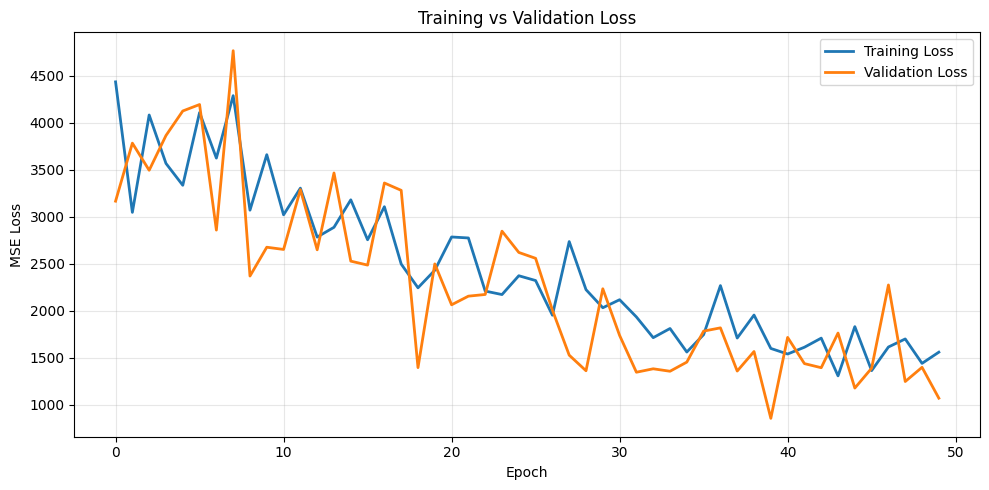

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PersonalizedFovPredictor(num_classes=12, d_model=256).to(device)

# Print initial user preferences
print("\n=== INITIAL USER PREFERENCES ===")
print("All weights initialized to 1.0:")
print(model.user_preference.data)
print()

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Storage for plotting
train_losses = []
val_losses = []

# Training loop
num_epochs = 50
print("Starting training...")

final_epoch_loss = 0, 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    for motion, semantics in train_loader:
        motion = motion.to(device)
        semantics = semantics.to(device)
        
        # Get ground truth (next position)
        # Use the last position as target (shift by 1 timestep)
        target = motion[:, -1, :]  # [B, 2]
        
        # Forward pass
        optimizer.zero_grad()
        prediction = model(motion[:, :-1, :], semantics[:, :-1, :, :])
        
        # Compute loss
        loss = criterion(prediction, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for motion, semantics in test_loader:
            motion = motion.to(device)
            semantics = semantics.to(device)
            
            target = motion[:, -1, :]
            prediction = model(motion[:, :-1, :], semantics[:, :-1, :, :])
            
            loss = criterion(prediction, target)
            val_loss += loss.item()
            val_batches += 1
    
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    if (epoch == 49):
        final_epoch_loss = (avg_train_loss, avg_val_loss)

print("\nTraining complete!")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=300)
plt.show()


=== SCIENTIFIC CHECK: LEARNED USER PREFERENCES ===

*** HYPOTHESIS TEST ***
Face (Class 1) weight: 0.9325
Building (Class 11) weight: 1.0000
Ratio (Face/Building): 0.93x
✗ HYPOTHESIS NOT CONFIRMED: Unexpected preference pattern


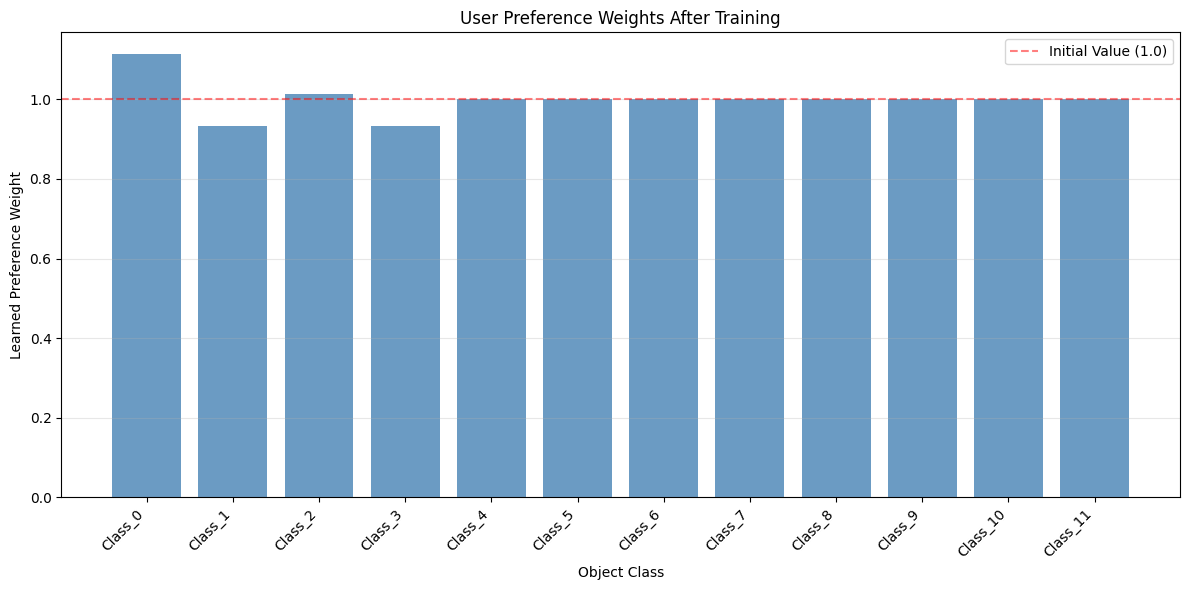


=== GENERATING PREDICTION VISUALIZATION ===


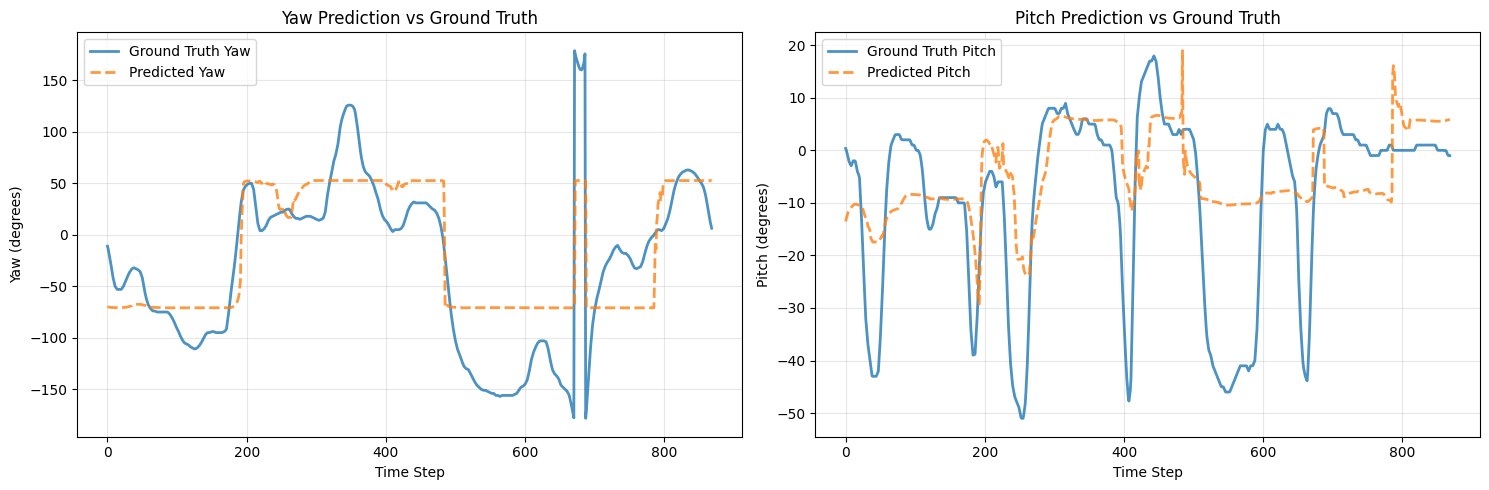


Learned Preference Weights:
  Class 0 (PAD):       	1.1128
  Class 1 (human face):       	0.9325
  Class 2 (person):       	1.0139
  Class 3 (vehicle):       	0.9339
  Class 4 (animal):       	1.0000
  Class 5 (text logo):       	1.0000
  Class 6 (sports ball):       	1.0000
  Class 7 (fireworks):       	1.0000
  Class 8 (waterfall):       	1.0000
  Class 9 (toy gun):       	1.0000
  Class 10 (mountain):       	1.0000
  Class 11 (building):       	1.0000

Sanity Test:
Face (Class 1) weight: 0.9325
Building (Class 11) weight: 1.0000
Ratio (Face/Building): 0.93x
HYPOTHESIS NOT CONFIRMED: Model failed to prioritize faces over buildings

Final Validation MSE - 1071.909058

Prediction MSE - Yaw: 2247.9761, Pitch: 232.5167


In [ ]:
print("\n=== SCIENTIFIC CHECK: LEARNED USER PREFERENCES ===")
learned_preferences = model.user_preference.detach().cpu().numpy()

# Key hypothesis check
face_weight = learned_preferences[1]
building_weight = learned_preferences[11]
print(f"\n*** HYPOTHESIS TEST ***")
print(f"Face (Class 1) weight: {face_weight:.4f}")
print(f"Building (Class 11) weight: {building_weight:.4f}")
print(f"Ratio (Face/Building): {face_weight/building_weight:.2f}x")

if face_weight > building_weight:
    print("✓ HYPOTHESIS CONFIRMED: Model learned to prioritize faces over buildings!")
else:
    print("✗ HYPOTHESIS NOT CONFIRMED: Unexpected preference pattern")

# Create bar chart
plt.figure(figsize=(12, 6))
class_names = [label_map.get(i, f"Class_{i}") for i in range(len(learned_preferences))]
plt.bar(range(len(learned_preferences)), learned_preferences, color='steelblue', alpha=0.8)
plt.xlabel('Object Class')
plt.ylabel('Learned Preference Weight')
plt.title('User Preference Weights After Training')
plt.xticks(range(len(learned_preferences)), class_names, rotation=45, ha='right')
plt.axhline(y=1.0, color='red', linestyle='--', label='Initial Value (1.0)', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('preference_weights.png', dpi=300)
plt.show()

print("\n=== GENERATING PREDICTION VISUALIZATION ===")

# Get one test sequence
model.eval()
with torch.no_grad():
    # Get first test sequence
    test_motion, test_semantics = data['test_sequences'][0]
    test_motion = test_motion.unsqueeze(0).to(device)  # Add batch dimension
    test_semantics = test_semantics.unsqueeze(0).to(device)
    
    # Generate predictions for each timestep
    seq_len = test_motion.shape[1]
    predictions = []
    
    # Use sliding window to predict at each timestep
    window_size = 29 
    for t in range(window_size, seq_len):
        motion_window = test_motion[:, t-window_size:t, :]
        sem_window = test_semantics[:, t-window_size:t, :, :]
        pred = model(motion_window, sem_window)
        predictions.append(pred.cpu().numpy()[0])
    
    predictions = np.array(predictions)
    ground_truth = test_motion[0, window_size:, :].cpu().numpy()

# Plot trajectories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Yaw comparison
ax1.plot(ground_truth[:, 0], label='Ground Truth Yaw', linewidth=2, alpha=0.8)
ax1.plot(predictions[:, 0], label='Predicted Yaw', linewidth=2, alpha=0.8, linestyle='--')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Yaw (degrees)')
ax1.set_title('Yaw Prediction vs Ground Truth')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Pitch comparison
ax2.plot(ground_truth[:, 1], label='Ground Truth Pitch', linewidth=2, alpha=0.8)
ax2.plot(predictions[:, 1], label='Predicted Pitch', linewidth=2, alpha=0.8, linestyle='--')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Pitch (degrees)')
ax2.set_title('Pitch Prediction vs Ground Truth')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_visualization.png', dpi=300)
plt.show()


# Build inverse map id -> name
label_map = data['meta']['label_map']
inv_label_map = {v: k for k, v in label_map.items()}

print("\nLearned Preference Weights:")
for i, weight in enumerate(learned_preferences):
    class_name = inv_label_map.get(i, f"Unknown_{i}")
    print(f"  Class {i} ({class_name}):       \t{weight:.4f}")

# Sanity check
face_weight = learned_preferences[1]
building_weight = learned_preferences[11]
print(f"\nSanity Test:")
print(f"Face (Class 1) weight: {face_weight:.4f}")
print(f"Building (Class 11) weight: {building_weight:.4f}")

if face_weight > building_weight:
    print("HYPOTHESIS CONFIRMED: Model learned to prioritize faces over buildings")
else:
    print("HYPOTHESIS NOT CONFIRMED: Model failed to prioritize faces over buildings")

print(f"\nFinal Validation MSE - {final_epoch_loss[1]:.6f}")

# Calculate prediction error
mse_yaw = np.mean((ground_truth[:, 0] - predictions[:, 0])**2)
mse_pitch = np.mean((ground_truth[:, 1] - predictions[:, 1])**2)
print(f"\nPrediction MSE - Yaw: {mse_yaw:.4f}, Pitch: {mse_pitch:.4f}")